In [338]:
import numpy as np
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import logsumexp
from copy import deepcopy
random.seed(42)

In [339]:
observation = '315116246446644245311321631164152133625144543631656626566666651166453132651245636664631636663162326455236266666625151631222555441666566563564324364131513465146353411126414626253356366163666466232534413661661163252562462255265252266435353336233121625364414432335163243633665562466662632666612355245242'
states = ['F', 'L']
start_prob = {
    'F' : 0.99,
    'L' : 0.01
}
trans_prob = {
    'F' : {'F' : 0.95,
           'L' : 0.05},
    'L' : {'L' : 0.9,
           'F' : 0.1}
}
emit_prob = {
    'F' : {'1' : 1/6,
           '2' : 1/6,
           '3' : 1/6,
           '4' : 1/6,
           '5' : 1/6,
           '6' : 1/6,},
    'L' : {'1' : 1/10,
           '2' : 1/10,
           '3' : 1/10,
           '4' : 1/10,
           '5' : 1/10,
           '6' : 1/2,}
}

In [340]:
def print_dict(prob_dict:dict, flag:str, title=''):
  '''
  Pretty printing of probabilities matricies
  flag - 1 expects simple dict, if 2 expects dict of dicts
  '''
  if flag == 2:
    print(title)
    for state, emit_probs in prob_dict.items():
        print(f"State: [{state}]")
        for observation, probability in emit_probs.items():
            print(f"  Observation [{observation}]: Probability {probability:.4f}")
  elif flag == 1:
    print(title)
    for observation, probability in prob_dict.items():
      print(f"  State [{observation}]: Probability {probability:.4f}")
  else:
    print('Incorrect flag! Must be 1 or 2')

In [341]:
def to_log(aim:dict, flag:int)->None:
  '''
  converts your dict of probs from [0:1] space to log space IN PLACE
  1. aim - dict of probabilites
  2. flag - 1 expects simple dict, if 2 expects dict of dicts
  '''
  if flag == 2:
    for key in aim:
      for key2 in aim[key]:
        aim[key][key2] = np.log(aim[key][key2])
  elif flag == 1:
    for key in aim:
        aim[key] = np.log(aim[key])
  else:
    print('Incorrect flag! Must be 1 or 2')


def from_log(aim:dict, flag:int)->None:
  '''
  returns your dict of probs from log space to [0:1] space IN PLACE
  1. aim - dict of probabilites
  2. flag - 1 expects simple dict, if 2 expects dict of dicts
  '''
  if flag == 2:
    for key in aim:
      for key2 in aim[key]:
        aim[key][key2] = np.exp(aim[key][key2])
  elif flag == 1:
    for key in aim:
        aim[key] = np.exp(aim[key])
  else:
    print('Incorrect flag! Must be 1 or 2')

In [342]:
def viterbi_alg(data:str, states:dict, start_prob:dict, trans_prob:dict, emit_prob:dict)->str:
    '''
      Aguments:
      1. data - your observation that needs to decode by viterby algorithm
      2. states - hidden states in HMM
      3. start_probs - dictionary where key is hidden state and value is probability of transition from 0 state
      4. trans_probs - dictionary where key is hidden state and value is dictionart where key is hidden state in
      which transition will occur and value is probability of whis transition
      5. emit_prob - dictionary where key is hidden state and value is dictionary where key is particular
      observation and value is probability of this observation emitted by state

      returns:
      1. Most probable sequence of hidden states
    '''
    # инициализируем список словарей для каждого шага
    V = [{}]
    # это словарь который будет содержать списки наиболее вероятных путей скрытых состояний. Начальных состояния два: может быть либо F либо L
    path = {}

    # сначала инициализируем все начальными состояниями
    for state in states:
        # начальное состояние задается произведением вероятности начального состояния для каждого state и эмисионной вероятностью первого символа
        V[0][state] = np.log(start_prob[state]) + np.log(emit_prob[state][data[0]])
        path[state] = [state]

    # самое сложное: алгоритм Витерби, для всех состояния после начального:
    for obs in range(1, len(data)):
        V.append({})
        new_path = {}

        for curr_state in states:
          # Все как в формуле:
          # сначала считаем вероятность эмиссии текущего элемента в текущем состоянии
          curr_emit = np.log(emit_prob[curr_state][data[obs]])
          # считаем вероятности прошлого временного шага, это лучшая вероятность прошлого наблюдения и вероятность перехода (в этом и заключается динамическое программирование)
          prev = [V[obs-1][previous_state] + np.log(trans_prob[previous_state][curr_state]) for previous_state in states]
          # выбираем максимум
          prev = max(prev)
          # умножаем на вероятнось эмиссии
          max_prob = prev + curr_emit
          # добавляем лучшую вероятность в словарь лучших вероятностей
          V[obs][curr_state] = max_prob

          # находим конкретное состояние при котором был лучший результат
          best_state = max((V[obs-1][prev_state] + np.log(trans_prob[prev_state][curr_state]) + np.log(emit_prob[curr_state][data[obs]]), prev_state) for prev_state in states)[1]

          # добавляем пути
          new_path[curr_state] = path[best_state] + [curr_state]

        # обновляем пути
        path = new_path

    # Ну и получаем самый вероятный путь:
    max_path = max((V[-1][state], path[state]) for state in states)[1]

    return ''.join(max_path)

In [343]:
def forward_alg(data:str, states:dict, start_prob:dict, trans_prob:dict, emit_prob:dict, logspace:bool=False)->tuple:
    '''
      Aguments:
      1. data - your observation - results of emittion
      2. states - hidden states in HMM
      3. start_probs - dictionary where key is hidden state and value is probability of transition from 0 state
      4. trans_probs - dictionary where key is hidden state and value is dictionart where key is hidden state in
      which transition will occur and value is probability of whis transition
      5. emit_prob - dictionary where key is hidden state and value is dictionary where key is particular
      observation and value is probability of this observation emitted by state
      6. logspace - True means that input data is in logspace
      returns:
      1. Joint probability of end step and array of joint probabilities in each step
    '''
    # отличие тут только в том что вместо максимума прошлых вероятностей, мы их суммируем
    # инициализируем список словарей для каждого шага
    V = [{}]
    # это словарь который будет содержать списки наиболее вероятных путей скрытых состояний. Начальных состояния два: может быть либо F либо L
    path = {}

    # сначала инициализируем все начальными состояниями
    for state in states:
        # начальное состояние задается произведением вероятности начального состояния для каждого state и эмисионной вероятностью первого символа
        if logspace:
          V[0][state] = start_prob[state] + emit_prob[state][data[0]]
        else:
          V[0][state] = np.log(start_prob[state]) + np.log(emit_prob[state][data[0]])

    for obs in range(1, len(data)):
        V.append({})

        for curr_state in states:
          # Все как в формуле:
          # сначала считаем вероятность эмиссии текущего элемента в текущем состоянии
          # считаем вероятности прошлого временного шага, это лучшая вероятность прошлого наблюдения и вероятность перехода (в этом и заключается динамическое программирование)
          # два варианта, когда входные данные уже в лог шкале и когда нет
          if logspace:
            curr_emit = emit_prob[curr_state][data[obs]]
            prev = [V[obs-1][previous_state] + trans_prob[previous_state][curr_state] for previous_state in states]

          else:
            curr_emit = np.log(emit_prob[curr_state][data[obs]])
            prev = [V[obs-1][previous_state] + np.log(trans_prob[previous_state][curr_state]) for previous_state in states]


          # суммируем
          prev = logsumexp(prev)
          # умножаем на вероятнось эмиссии
          prob = prev + curr_emit
          # добавляем полную вероятность в словарь вероятностей
          V[obs][curr_state] = prob

    # Получаем общую вероятность на последнем шаге
    joint_prob = logsumexp([V[-1][state] for state in states])
    # и вектора вероятностей
    f = np.array([list(x.values()) for x in V])
    return joint_prob, f

In [361]:
def backward_alg(observation:str, states:dict, trans_prob:dict, emit_prob:dict, logspace:bool=False)->np.array:
  '''
      Aguments:
      1. observation - your observation - results of emittion
      2. states - hidden states in HMM
      3. trans_probs - dictionary where key is hidden state and value is dictionart where key is hidden state in
      which transition will occur and value is probability of whis transition
      4. emit_prob - dictionary where key is hidden state and value is dictionary where key is particular
      observation and value is probability of this observation emitted by state
      5. logspace - True means that input data is in logspace
      returns:
      1. Probability of emitted value by certain state
  '''
  # инициализируем словарь
  beta = {}
  for state in states:
    # сначала создаем два ключа - это наши состояния, и каждый ключ это список длины L-1 (последний самый элемент - 1, вероятность получить последний элемент принимаем за единицу, ибо не задано конечное распределение)
      beta.setdefault(state, ([0]*len(observation)))
  # сложный цикл: итерируемся L-2 (последний элемент уже инициализирован, это единица, ну и еще минус один что бы начать с конца), до 0 включительно в обратном порядке
  for index in range(len(observation)-2,-1,-1):
    for state in states:
      # ну собственно формула: для каждого состония считаем произведение эмиссии и перехода на beta с шага i+1
      if logspace:
        beta[state][index] = logsumexp([trans_prob[state][next_state] + emit_prob[next_state][observation[index+1]] + beta[next_state][index+1] for next_state in states])
      else:
        beta[state][index] = logsumexp([np.log(trans_prob[state][next_state]) + np.log(emit_prob[next_state][observation[index+1]]) + beta[next_state][index+1] for next_state in states])
  beta = [[x,y] for x,y in zip(beta['F'], beta['L'])]
  # возвращаем в удобной форме
  return np.array(beta)

In [345]:
viterbi_alg(observation, states, start_prob, trans_prob, emit_prob)

'FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFLLLLLLLLLLLLLLLLLLFFFFFFFFFFFFLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFLLLLLLLLLLLLLFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFLLLLLLLLLLLLLLLLLLLFFFFFFFFFFF'

In [346]:
def generate_sequence(start_prob, trans_prob, size):
  F = [1,2,3,4,5,6] # в случае с fair - все равновероятно
  L = [1,2,3,4,5] + [6]*5 # тут 10 элементов, 5 из которых шестерки - 5/10 = 1/2 вероятность вытащить шестерку, остальные вероятности .1
  state_path = []
  emit_path = []
  # инициализируем на первом шаге руками path и emit
  state_path.append('F' if random.random() <= start_prob['F'] else 'L')
  emit_path.append(F[random.randint(0,len(F)-1)] if state_path[-1] == 'F' else L[random.randint(0, len(L)-1)])
  for i in range(1, size):
    if state_path[-1] == 'F':
      state_path.append('F' if random.random() <= trans_prob['F']['F'] else 'L')
    else:
      state_path.append('L' if random.random() <= trans_prob['L']['L'] else 'F')
    emit_path.append(F[random.randint(0,len(F)-1)] if state_path[-1] == 'F' else L[random.randint(0, len(L)-1)])

  return (''.join(state_path), ''.join(list(map(str, emit_path))))

In [347]:
M = np.array([[0.95, 0.05], [0.9, 0.1]])
x = np.array([0.99, 0.01])
eigen = x@M
for i in range(100):
  eigen = eigen@M
eigen

array([0.94736842, 0.05263158])

In [348]:
start_prob_for_generating = {
    'F' : eigen[0],
    'L' : eigen[1]
}
L = len(observation)

In [349]:
generated_hidden_states, generated_emittes = generate_sequence(start_prob_for_generating, trans_prob, L)

In [350]:
generated_hidden_states

'FFFFFFFFFFFFFFFFLLLLLLLLLLLLLLLLLLLLLLLLLLLFFFFFFFFFFFFFFFFFFFFFFFFFLLLLLLLFFFFFFFFFFFFLLLFFFFFFFFFFFFFFFFFFFFFFFFFFFFFLFFFFFFFLLLLLLLLLLLLLLLLLFFFFFFFLLLFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFLFFFFFFFFFFFFFFFLLLLLLLLLLLLLLLFFFFFFFFFFFFFFFFFFFFFFFFFLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLFFFFFFFFFFFFFFFFFFFFFFFF'

In [351]:
generated_emittes

'126611252623123266616656624226665234666116453463634421124445115634633256336513321452554646652352621132652413416412231561244244666516666632466266234631524313466631212536514123441653211265432213463612426315661556666116423665462662312534561632222626641246626666636456424624326666151346544466454664323441'

In [352]:
viterbi_predicted_hidden_states = viterbi_alg(generated_emittes, states, start_prob_for_generating, trans_prob, emit_prob)

In [353]:
viterbi_predicted_hidden_states

'FFFFFFFFFFFFFFFFLLLLLLLLLLLLLLLLLLLLLLLFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFLLLLLLLLLLLLLLLLLLFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFLLLLLLLLLLLLLLLLLLLLLLLFFFFFFFFFFFFFFFFLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLFFFFFFFFFFFFFFFFFFFFFFFF'

In [354]:
def plot_hidden_states(hidden_states, predicted_hidden_states, title='Real Hidden States vs Predicted Hidden States (Viterbi)'):
  # Создаем список индексов для оси X
  x_values = range(len(hidden_states))
  # Размеры графика
  plt.figure(figsize=(10, 6))
  # График реальных скрытых состояний
  plt.plot(x_values, [0 if state == 'F' else 1 for state in hidden_states], label='σ', color='green')
  # График предсказанных скрытых состояний (алгоритм Витерби)
  plt.plot(x_values[:-1], [0 if state == 'F' else 1 for state in predicted_hidden_states[:-1]], label='σv', color='red', linestyle='--')
  # Добавляем легенду
  plt.legend()
  # Настройки осей и заголовок
  plt.title(title)
  plt.xlabel('Position')
  plt.ylabel('State (0 - Fair, 1 - Loaded)')
  # Отображаем график
  plt.grid(True)
  plt.show()

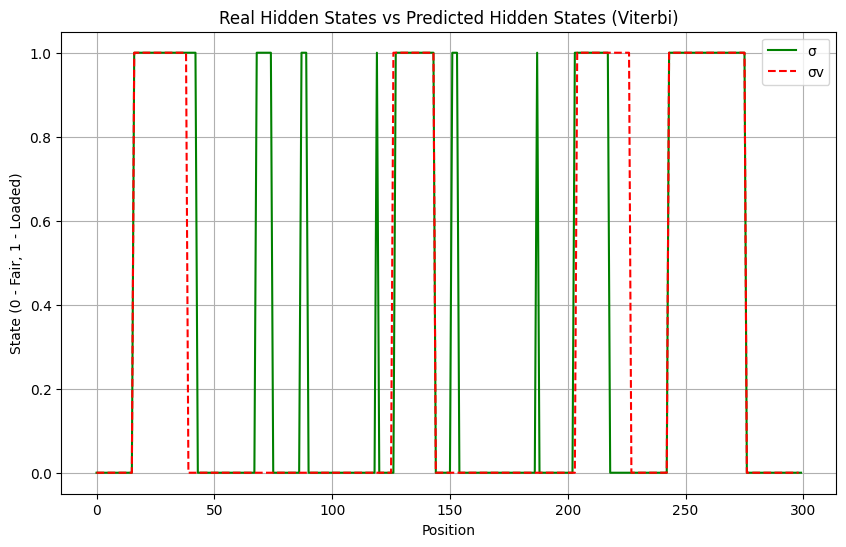

In [355]:
plot_hidden_states(generated_hidden_states, viterbi_predicted_hidden_states)

In [356]:
joint_prob_for_gen_seq, f = forward_alg(generated_emittes, states, start_prob_for_generating, trans_prob, emit_prob)

In [362]:
b = backward_alg(generated_emittes, states, trans_prob, emit_prob)

In [364]:
post_probs = f + b - joint_prob_for_gen_seq

In [366]:
# Теперь напишем функцию для отрисовки графика апостериорной вероятности
def plot_pp(probs, hidden_states, title='Posterior Probability', xlabel='Number of the rolls', ylabel='P(Fair)'):
  plt.figure(figsize=(15, 5))
  plt.plot(probs[:,0], color='green', alpha=0.5)
  plt.fill_between(range(len(probs[:,0])), probs[:,0], color='grey', alpha=0.5)
  plt.title(title)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  for i in range(len(hidden_states)):
      if hidden_states[i] == 'L':
          plt.fill_between([i, i + 1], 0, 1, color='red', alpha=0.3)
  plt.show()

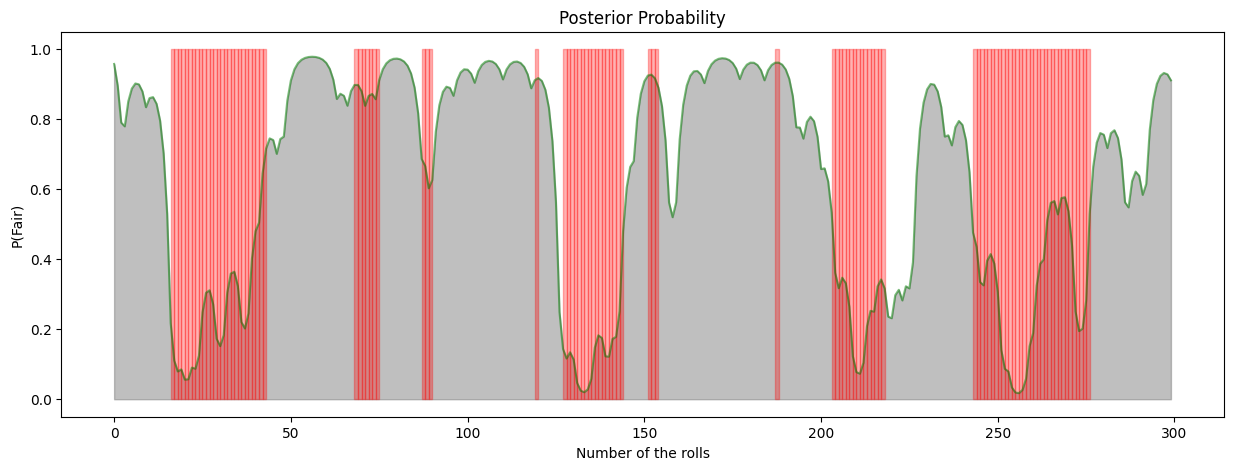

In [367]:
plot_pp(np.exp(post_probs), generated_hidden_states)

In [368]:
def posterior_decoding(post_probs, states):
    decoded_states = []
    for probs in post_probs:
        max_prob_index = probs.argmax()  # Находим индекс состояния с наибольшей вероятностью
        decoded_states.append(states[max_prob_index])  # Добавляем скрытое состояние к последовательности
    return ''.join(decoded_states)

In [369]:
posterior_decoding(post_probs, states)

'FFFFFFFFFFFFFFFFLLLLLLLLLLLLLLLLLLLLLLLLLFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFLLLLLLLLLLLLLLLLLLLFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFLLLLLLLLLLLLLLLLLLLLLLLFFFFFFFFFFFFFFFFLLLLLLLLLLLLLLLLLLLLLFFFFFFFLLLLLFFFFFFFFFFFFFFFFFFFFFFFF'

In [370]:
def baum_welch(observation, states, start_prob_, trans_prob_, emit_prob_, max_iter=100):
    T = len(observation)
    N = len(states)
    start_prob_BW = deepcopy(start_prob_)
    trans_prob_BW = deepcopy(trans_prob_)
    emit_prob_BW = deepcopy(emit_prob_)

    to_log(start_prob_BW, 1)
    to_log(trans_prob_BW, 2)
    to_log(emit_prob_BW, 2)
    # Итерационный процесс
    for _ in range(max_iter):
        # E-шаг: вычисление вероятностей скрытых состояний
        _, alpha = forward_alg(observation, states, start_prob_BW, trans_prob_BW, emit_prob_BW, logspace=True)
        beta = backward_alg(observation, states, trans_prob_BW, emit_prob_BW, logspace=True)

        # M-шаг: обновление параметров HMM
        for i, state_from in enumerate(states):
            for j, state_to in enumerate(states):
                trans_prob_BW[state_from][state_to] = logsumexp([alpha[t, i] + trans_prob_BW[state_from][state_to] + emit_prob_BW[state_to][observation[t + 1]] + beta[t + 1, j] for t in range(T - 1)]) - logsumexp([alpha[t, i] + beta[t, i] for t in range(T - 1)])

        for i, state in enumerate(states):
            for k in emit_prob_BW[state]:
                emit_prob_BW[state][k] = logsumexp([alpha[t, i] + beta[t, i] for t in range(T) if observation[t] == k]) - logsumexp([alpha[t, i] + beta[t, i] for t in range(T)])

        for i, state in enumerate(states):
            start_prob_BW[state] = alpha[0, i] + beta[0, i] - logsumexp([alpha[0, j] + beta[0, j] for j in range(N)])
    from_log(start_prob_BW, 1)
    from_log(trans_prob_BW, 2)
    from_log(emit_prob_BW, 2)
    return start_prob_BW, trans_prob_BW, emit_prob_BW

In [ ]:
#generated_hidden_states
#states
#generated_emittes
#start_prob_for_generating
#trans_prob
#emit_prob

In [300]:
start_prob_for_generating

{'F': 0.9473684210526314, 'L': 0.05263157894736842}

In [302]:
trans_prob

{'F': {'F': 0.95, 'L': 0.05}, 'L': {'L': 0.9, 'F': 0.1}}

In [334]:
BW_star_probs, BW_trans_probs, BW_emit_probs = baum_welch(generated_emittes, states, start_prob_for_generating, trans_prob, emit_prob, max_iter=100)

In [335]:
print_dict(BW_star_probs, 1, 'Start probabilities for each state:')

Start probabilities for each state:
  State [F]: Probability 1.0000
  State [L]: Probability 0.0000


In [336]:
print_dict(BW_trans_probs, 2, 'Transition probabilities for each state:')

Transition probabilities for each state:
State: [F]
  Observation [F]: Probability 0.9586
  Observation [L]: Probability 0.0414
State: [L]
  Observation [L]: Probability 0.9439
  Observation [F]: Probability 0.0561


In [337]:
print_dict(BW_emit_probs, 2, 'EEmission probabilities for each state:')

EEmission probabilities for each state:
State: [F]
  Observation [1]: Probability 0.1868
  Observation [2]: Probability 0.1871
  Observation [3]: Probability 0.1694
  Observation [4]: Probability 0.1567
  Observation [5]: Probability 0.1176
  Observation [6]: Probability 0.1824
State: [L]
  Observation [1]: Probability 0.0745
  Observation [2]: Probability 0.1540
  Observation [3]: Probability 0.0748
  Observation [4]: Probability 0.1646
  Observation [5]: Probability 0.0833
  Observation [6]: Probability 0.4488


# Выглядит правдоподобно

# Теперь сгенерируем последовательности длины 100, 500, 1000


In [316]:
generated_hidden_states_100, generated_emittes_100 = generate_sequence(start_prob_for_generating, trans_prob, 100)
generated_hidden_states_500, generated_emittes_500 = generate_sequence(start_prob_for_generating, trans_prob, 500)
generated_hidden_states_1000, generated_emittes_1000 = generate_sequence(start_prob_for_generating, trans_prob, 1000)

In [317]:
viterbi_predicted_hidden_states_100 = viterbi_alg(generated_emittes_100, states, start_prob_for_generating, trans_prob, emit_prob)
viterbi_predicted_hidden_states_500 = viterbi_alg(generated_emittes_500, states, start_prob_for_generating, trans_prob, emit_prob)
viterbi_predicted_hidden_states_1000 = viterbi_alg(generated_emittes_1000, states, start_prob_for_generating, trans_prob, emit_prob)

In [318]:
joint_prob_for_gen_seq_100, f_100 = forward_alg(generated_emittes_100, states, start_prob_for_generating, trans_prob, emit_prob)
joint_prob_for_gen_seq_500, f_500 = forward_alg(generated_emittes_500, states, start_prob_for_generating, trans_prob, emit_prob)
joint_prob_for_gen_seq_1000, f_1000 = forward_alg(generated_emittes_1000, states, start_prob_for_generating, trans_prob, emit_prob)

b_100 = backward_alg(generated_emittes_100, states, trans_prob, emit_prob)
b_500 = backward_alg(generated_emittes_500, states, trans_prob, emit_prob)
b_1000 = backward_alg(generated_emittes_1000, states, trans_prob, emit_prob)

post_probs_100 = f_100 + b_100 - joint_prob_for_gen_seq_100
post_probs_500 = f_500 + b_500 - joint_prob_for_gen_seq_500
post_probs_1000 = f_1000 + b_1000 - joint_prob_for_gen_seq_1000

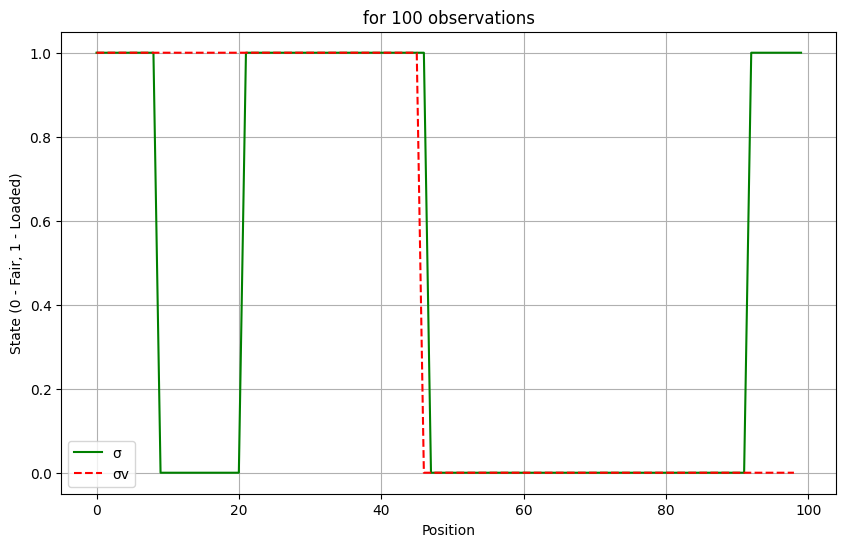

In [320]:
plot_hidden_states(generated_hidden_states_100, viterbi_predicted_hidden_states_100, title='for 100 observations')

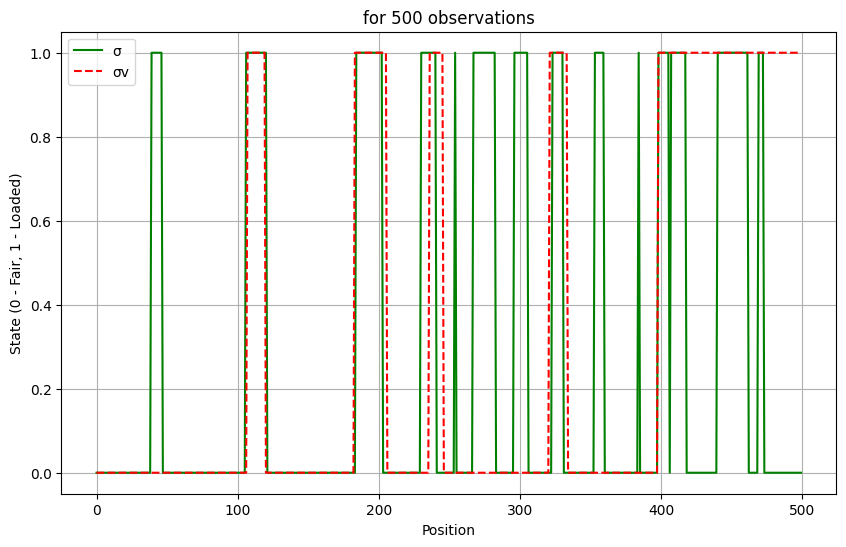

In [321]:
plot_hidden_states(generated_hidden_states_500, viterbi_predicted_hidden_states_500, title='for 500 observations')

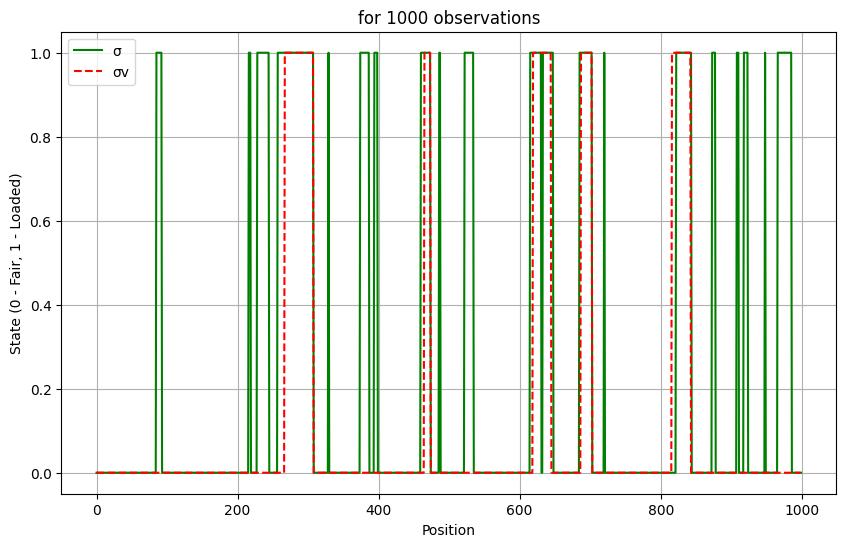

In [322]:
plot_hidden_states(generated_hidden_states_1000, viterbi_predicted_hidden_states_1000, title='for 1000 observations')

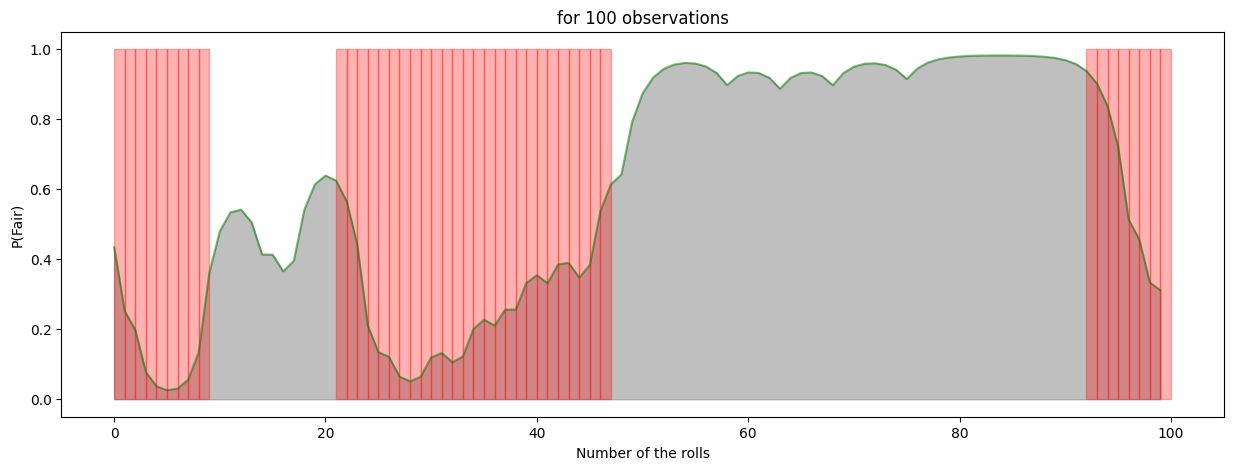

In [323]:
plot_pp(np.exp(post_probs_100), generated_hidden_states_100, title='for 100 observations')

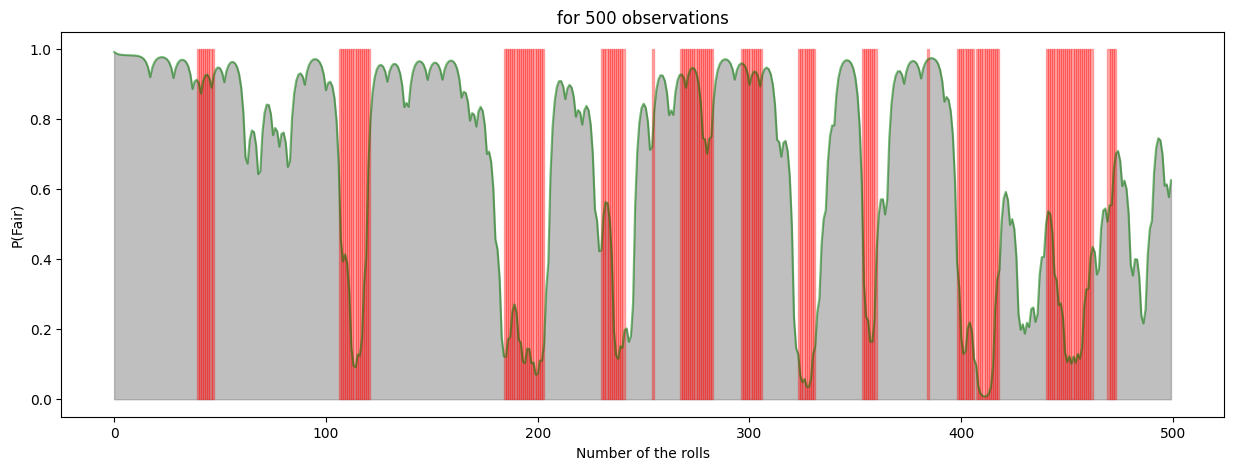

In [324]:
plot_pp(np.exp(post_probs_500), generated_hidden_states_500, title='for 500 observations')

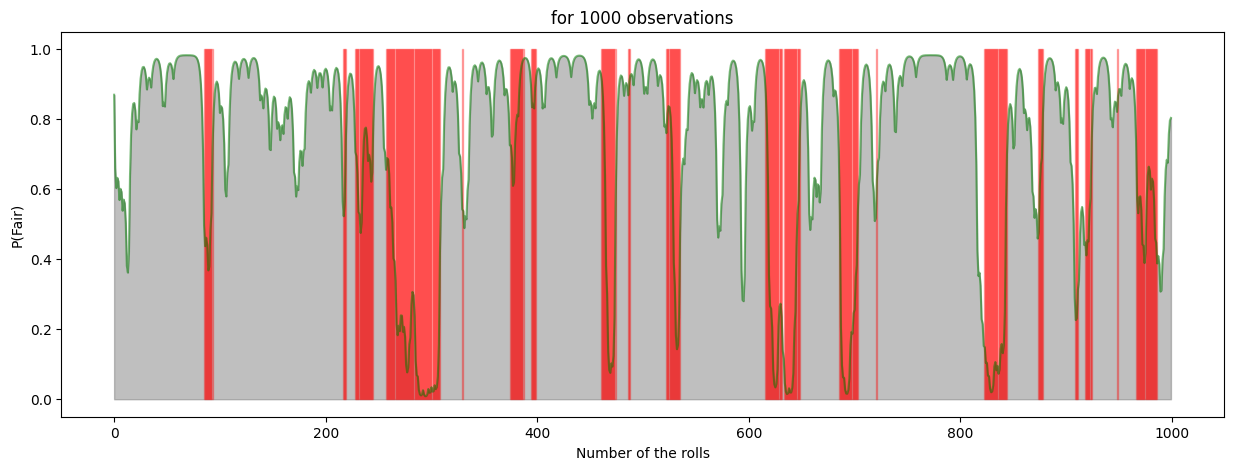

In [325]:
plot_pp(np.exp(post_probs_1000), generated_hidden_states_1000, title='for 1000 observations')

In [327]:
BW_star_probs_100, BW_trans_probs_100, BW_emit_probs_100 = baum_welch(generated_emittes_100, states, start_prob_for_generating, trans_prob, emit_prob, max_iter=100)
BW_star_probs_500, BW_trans_probs_500, BW_emit_probs_500 = baum_welch(generated_emittes_500, states, start_prob_for_generating, trans_prob, emit_prob, max_iter=100)
BW_star_probs_1000, BW_trans_probs_1000, BW_emit_probs_1000 = baum_welch(generated_emittes_1000, states, start_prob_for_generating, trans_prob, emit_prob, max_iter=100)

In [328]:
print_dict(BW_star_probs_100, 1, 'Start probabilities for each state (length of sequence = 100):')
print_dict(BW_trans_probs_100, 2, 'Transition probabilities for each state (length of sequence = 100):')
print_dict(BW_emit_probs_100, 2, 'EEmission probabilities for each state (length of sequence = 100):')

Start probabilities for each state (length of sequence = 100):
  State [F]: Probability 0.0000
  State [L]: Probability 1.0000
Transition probabilities for each state (length of sequence = 100):
State: [F]
  Observation [F]: Probability 0.9606
  Observation [L]: Probability 0.0394
State: [L]
  Observation [L]: Probability 0.9410
  Observation [F]: Probability 0.0590
EEmission probabilities for each state (length of sequence = 100):
State: [F]
  Observation [1]: Probability 0.1754
  Observation [2]: Probability 0.1712
  Observation [3]: Probability 0.1532
  Observation [4]: Probability 0.2503
  Observation [5]: Probability 0.1272
  Observation [6]: Probability 0.1227
State: [L]
  Observation [1]: Probability 0.0000
  Observation [2]: Probability 0.1451
  Observation [3]: Probability 0.0527
  Observation [4]: Probability 0.1100
  Observation [5]: Probability 0.1337
  Observation [6]: Probability 0.5585


In [329]:
print_dict(BW_star_probs_500, 1, 'Start probabilities for each state (length of sequence = 500):')
print_dict(BW_trans_probs_500, 2, 'Transition probabilities for each state (length of sequence = 500):')
print_dict(BW_emit_probs_500, 2, 'EEmission probabilities for each state (length of sequence = 500):')

Start probabilities for each state (length of sequence = 500):
  State [F]: Probability 1.0000
  State [L]: Probability 0.0000
Transition probabilities for each state (length of sequence = 500):
State: [F]
  Observation [F]: Probability 0.9754
  Observation [L]: Probability 0.0246
State: [L]
  Observation [L]: Probability 0.9641
  Observation [F]: Probability 0.0359
EEmission probabilities for each state (length of sequence = 500):
State: [F]
  Observation [1]: Probability 0.1530
  Observation [2]: Probability 0.1956
  Observation [3]: Probability 0.1481
  Observation [4]: Probability 0.1673
  Observation [5]: Probability 0.1594
  Observation [6]: Probability 0.1766
State: [L]
  Observation [1]: Probability 0.0840
  Observation [2]: Probability 0.1199
  Observation [3]: Probability 0.1172
  Observation [4]: Probability 0.0822
  Observation [5]: Probability 0.1661
  Observation [6]: Probability 0.4306


In [330]:
print_dict(BW_star_probs_1000, 1, 'Start probabilities for each state (length of sequence = 1000):')
print_dict(BW_trans_probs_1000, 2, 'Transition probabilities for each state (length of sequence = 1000):')
print_dict(BW_emit_probs_1000, 2, 'EEmission probabilities for each state (length of sequence = 1000):')

Start probabilities for each state (length of sequence = 1000):
  State [F]: Probability 0.0000
  State [L]: Probability 1.0000
Transition probabilities for each state (length of sequence = 1000):
State: [F]
  Observation [F]: Probability 0.9889
  Observation [L]: Probability 0.0111
State: [L]
  Observation [L]: Probability 0.9259
  Observation [F]: Probability 0.0741
EEmission probabilities for each state (length of sequence = 1000):
State: [F]
  Observation [1]: Probability 0.1443
  Observation [2]: Probability 0.1576
  Observation [3]: Probability 0.1584
  Observation [4]: Probability 0.1746
  Observation [5]: Probability 0.1696
  Observation [6]: Probability 0.1954
State: [L]
  Observation [1]: Probability 0.0928
  Observation [2]: Probability 0.0898
  Observation [3]: Probability 0.0638
  Observation [4]: Probability 0.0925
  Observation [5]: Probability 0.0876
  Observation [6]: Probability 0.5736
